### Derive Chemistry DSA103 Data Project
- Author: Julian Stoerr
- Date: 30 November 2025 to 01.12.2025  


This notebook implements a Python based re-analysis of plant metabolite data from the Walker et al. (2023) Paper. The objective is to extract chemical data from the provided `mtbs_tropical_annotations.tsv` dataset and perform and apply dimensionality reduction as well as unsupervised learning to identify underlying structures in the data. 


The workflow includes:
- Data cleaning and filtering
- Chemical descriptor extraction
- Dimensionality reduction using PCA
- Unsupervised clustering using KMeans algorithm and optimisation using silhouette analysis
- Correlation analysis and visualisation

Necessary Libraries:
- pandas
- matplotlib
- seaborn
- RDKit
- Scikit-Learn

In [97]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from rdkit.Chem import Descriptors

### Data Loading, Exploration and Filtering
The metabolic dataset is loaded and inspected for completeness. Initial checks include structure validity, missing values (NA) and inspection of key columns

In [98]:
tropical_df = pd.read_csv("../data/mtbs_tropical_annotations.tsv",sep="\t")
tropical_df.head(3)

,feature_id,component_id,libname,structure_inchikey,structure_smiles,structure_molecular_formula,structure_taxonomy_npclassifier_01pathway,structure_taxonomy_npclassifier_02superclass,structure_taxonomy_npclassifier_03class
0,64000,2173,MS1_match,SRBFZHDQGSBBOR-HWQSCIPKSA-N,OC1OC[C@H](O)[C@H](O)[C@H]1O,C5H10O5,Carbohydrates,Saccharides,Monosaccharides
1,64000,2173,MS1_match,PYMYPHUHKUWMLA-WDCZJNDASA-N,O=C[C@@H](O)[C@H](O)[C@H](O)CO,C5H10O5,Carbohydrates,Saccharides,Monosaccharides
2,63994,2138,MS1_match,GLDOVTGHNKAZLK-UHFFFAOYSA-N,CCCCCCCCCCCCCCCCCCO,C18H38O,Fatty acids,Fatty acyls,Fatty alcohols


### Data cleaning
Metabolites wihtout valid SMILES strings and with no identifier at all were removed to ensure reliable descriptors. Only molecules with valid descriptors were retained. When multiple records showed the same molecular identifier, data were grouped by SMILES code

In [99]:
mask = (
    tropical_df["structure_smiles"].notna() & 
    tropical_df["structure_smiles"].ne("") 

)

compounds_ok = tropical_df[mask]



In [100]:
compounds_ok.groupby("structure_smiles")

In [101]:
def most_common(series):
    counts = series.value_counts(dropna=True)
    if len(counts) == 0:
        return None
    else:
        return counts.idxmax()

In [102]:
compReady = (
    compounds_ok
    .groupby("structure_smiles")["structure_taxonomy_npclassifier_01pathway"]
    .agg(most_common)
    .reset_index()
)


In [103]:
print(compReady.shape)
compReady.head(5)


(24046, 2)


,structure_smiles,structure_taxonomy_npclassifier_01pathway
0,C#C/C=C\CCCC#C/C=C/CCCCCCC/C=C\C#C,Fatty acids
1,C#C/C=C\CCCC#CCCCCCCCCCCC#C,Fatty acids
2,C#C/C=C\CCCCC#CCCCCC#CCCCC#CCO,Fatty acids
3,C#CC#CC/C=C/CCCCC/C=C/C(=O)N1CCCCC1,Alkaloids
4,C#CC#CC=CC=CC=CCCO,Fatty acids


In [104]:
compReady["SID"] = "S" + (compReady.index + 1).astype(str)

In [105]:
compReady.head(5)

,structure_smiles,structure_taxonomy_npclassifier_01pathway,SID
0,C#C/C=C\CCCC#C/C=C/CCCCCCC/C=C\C#C,Fatty acids,S1
1,C#C/C=C\CCCC#CCCCCCCCCCCC#C,Fatty acids,S2
2,C#C/C=C\CCCCC#CCCCCC#CCCCC#CCO,Fatty acids,S3
3,C#CC#CC/C=C/CCCCC/C=C/C(=O)N1CCCCC1,Alkaloids,S4
4,C#CC#CC=CC=CC=CCCO,Fatty acids,S5


In [106]:
#do not use these descriptors:   redundant <- c(2, 7, 8, 11, 15, 17, 18, 20, 21, 24, 29, 33:38, 41, 43:45)

redundant = (
    [2, 7, 8, 11, 15, 17, 18, 20, 21, 24, 29] +
    list(range(33, 39)) +
    [41] +
    list(range(43, 46))
)
redundant = [i - 1 for i in redundant]

all_desc = list(Descriptors.descList)

desc_used = []

for id, name in enumerate(all_desc):
    if id not in redundant:
        desc_used.append(name)
print(desc_used)



[('MaxAbsEStateIndex', <function MaxAbsEStateIndex at 0x000002BEC3EEED40>), ('MinAbsEStateIndex', <function MinAbsEStateIndex at 0x000002BEC3EEEDE0>), ('MinEStateIndex', <function MinEStateIndex at 0x000002BEC3EEECA0>), ('qed', <function qed at 0x000002BEC3F25DA0>), ('SPS', <function SPS at 0x000002BEC3F26340>), ('ExactMolWt', <function <lambda> at 0x000002BEC3F26B60>), ('NumValenceElectrons', <function NumValenceElectrons at 0x000002BEC3F26C00>), ('MaxPartialCharge', <function MaxPartialCharge at 0x000002BEC3F26DE0>), ('MinPartialCharge', <function MinPartialCharge at 0x000002BEC3F26E80>), ('MaxAbsPartialCharge', <function MaxAbsPartialCharge at 0x000002BEC3F26F20>), ('FpDensityMorgan1', <function FpDensityMorgan1 at 0x000002BEC3F271A0>), ('BCUT2D_MWHI', <function BCUT2D_MWHI at 0x000002BEC3F27380>), ('BCUT2D_CHGLO', <function BCUT2D_CHGLO at 0x000002BEC3F27560>), ('BCUT2D_LOGPHI', <function BCUT2D_LOGPHI at 0x000002BEC3F27600>), ('BCUT2D_MRHI', <function BCUT2D_MRHI at 0x000002BEC3F2

In [107]:
from rdkit import Chem
compReady["mol"] = compReady["structure_smiles"].apply(Chem.MolFromSmiles)

In [108]:
rows = []

for mol in compReady["mol"]:
    row = {}
    for name, func in desc_used:
        row[name] = func(mol)

    rows.append(row)

desc_df = pd.DataFrame(rows)
#desc_df.head(5)





In [109]:
compOut = pd.concat(
    [compReady.reset_index(drop=True), desc_df],
    axis=1
)
print(compOut.shape)
compOut.head(5)


(24046, 200)


,structure_smiles,structure_taxonomy_npclassifier_01pathway,SID,mol,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,C#C/C=C\CCCC#C/C=C/CCCCCCC/C=C\C#C,Fatty acids,S1,<rdkit.Chem.rdchem.Mol object at 0x000002BF410...,5.138392,0.937871,0.937871,0.332032,10.636364,292.219101,...,0,0,0,2,0,0,0,0,8,0
1,C#C/C=C\CCCC#CCCCCCCCCCCC#C,Fatty acids,S2,<rdkit.Chem.rdchem.Mol object at 0x000002BF410...,5.223961,0.943318,0.943318,0.309396,9.809524,282.234751,...,0,0,0,2,0,0,0,0,11,0
2,C#C/C=C\CCCCC#CCCCCC#CCCCC#CCO,Fatty acids,S3,<rdkit.Chem.rdchem.Mol object at 0x000002BF410...,8.490439,0.043231,-0.043231,0.492037,9.043478,308.214016,...,0,0,0,1,0,0,0,0,8,0
3,C#CC#CC/C=C/CCCCC/C=C/C(=O)N1CCCCC1,Alkaloids,S4,<rdkit.Chem.rdchem.Mol object at 0x000002BF410...,11.886906,0.190474,0.190474,0.285907,14.772727,297.209264,...,0,0,0,1,0,0,0,0,4,0
4,C#CC#CC=CC=CC=CCCO,Fatty acids,S5,<rdkit.Chem.rdchem.Mol object at 0x000002BF410...,8.439692,0.188318,0.188318,0.504961,10.461538,172.088815,...,0,0,0,1,0,0,0,0,0,0


In [110]:
#for col in compOut.columns:
#    print(f"{col}: {compOut[col].nunique()}")

### Principle Component Analysis (PCA)
PCA was applied to the standardised numerical chemical data to reduce dimensionality, identify dominant axes explaining major data variance and enable us to visualise high-dimensional data.

[0.1795839  0.10523412]


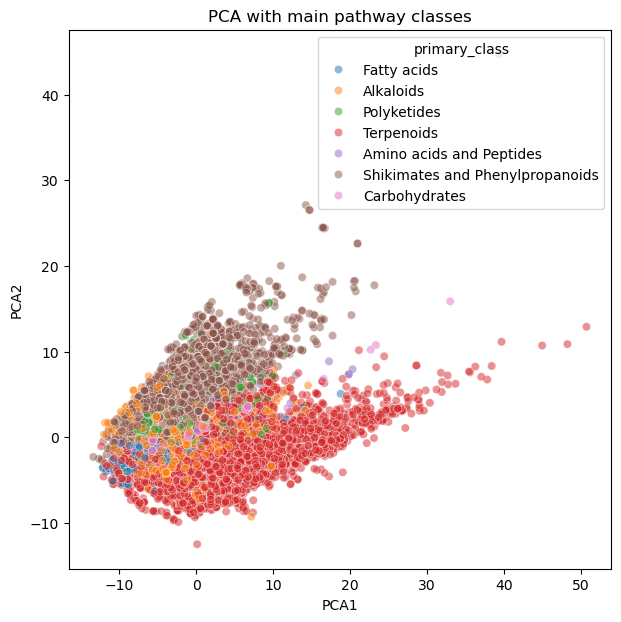

In [111]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

compOut_num = compOut.copy().select_dtypes("number")
#compOut_num.head(5)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(compOut_num)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print(pca.explained_variance_ratio_) #-> PCA1 explains 18% of variance and PCA2 11%

pca_df = pd.DataFrame(X_pca,columns=["PCA1","PCA2"])
pca_df["structure_taxonomy_npclassifier_01pathway"] = compOut["structure_taxonomy_npclassifier_01pathway"]
pca_df["primary_class"] = pca_df["structure_taxonomy_npclassifier_01pathway"].str.split("|").str[0]

plt.figure(figsize=[7,7])
sns.scatterplot(data=pca_df,x="PCA1",y="PCA2",hue="primary_class",alpha=0.5)
#plt.legend().remove()
plt.title("PCA with main pathway classes")
plt.show()



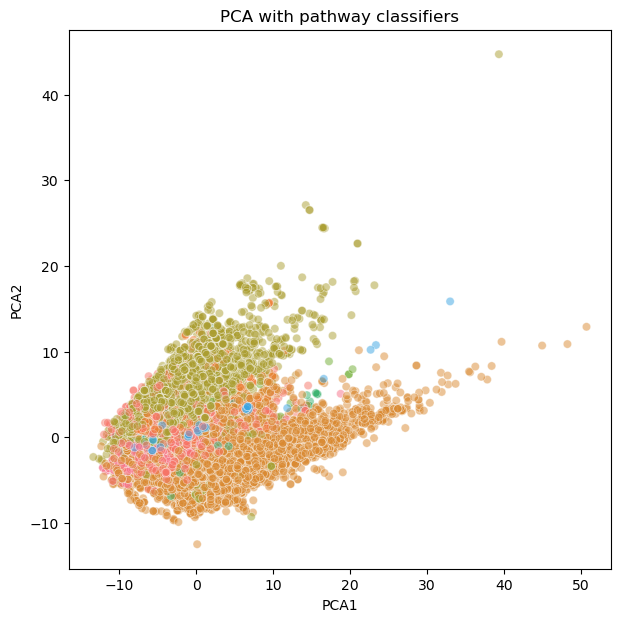

In [112]:
plt.figure(figsize=[7,7])
sns.scatterplot(data=pca_df,x="PCA1",y="PCA2",hue="structure_taxonomy_npclassifier_01pathway",alpha=0.5)
plt.legend().remove()
plt.title("PCA with pathway classifiers")
plt.show()

### KMeans Clustering
- To identify distinct chemical groups, the KMeans clustering algorithm was performed in the PCA space. The number of clusters was evaluated using silhouette-analysis to identify an _optimal_ number of clusters in the data. CLuster centers were summarised using the mean descriptor values to interpret dominant molecular signals.

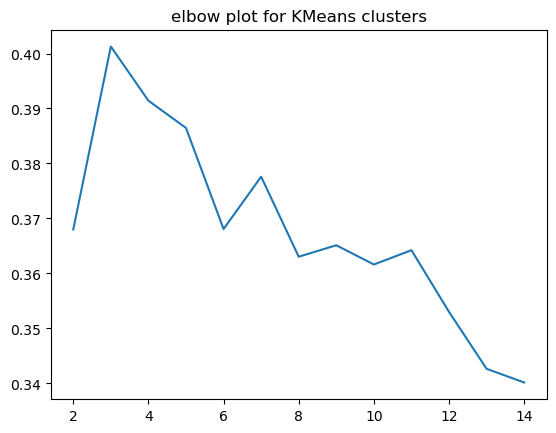

In [113]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



scores = []
x = list(range(2,15))

for i in range(2,15):
    km = KMeans(n_clusters=i,random_state=42).fit_predict(X_pca)
    score = silhouette_score(X_pca,km)
    scores.append(score)

sns.lineplot(x=x,y=scores,markers="o")
plt.title("elbow plot for KMeans clusters")
plt.show()

#use 3 clusters as it has the highest score


<Axes: xlabel='PCA1', ylabel='PCA2'>

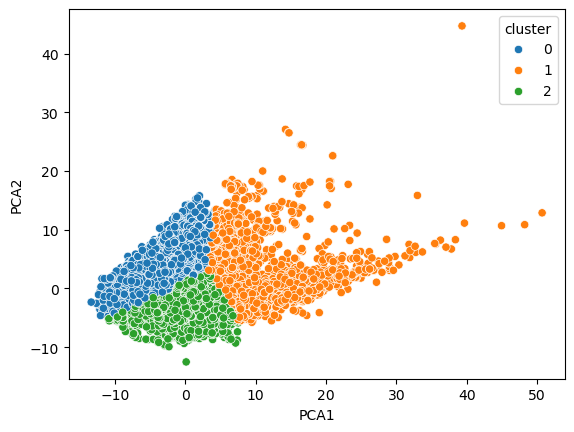

In [114]:
kmean = KMeans(n_clusters=3,random_state=42)
kmean_df = pca_df.copy()
kmean_df["cluster"] = kmean.fit_predict(X_pca)

sns.scatterplot(data=kmean_df, x="PCA1", y="PCA2", hue="cluster", palette="tab10")

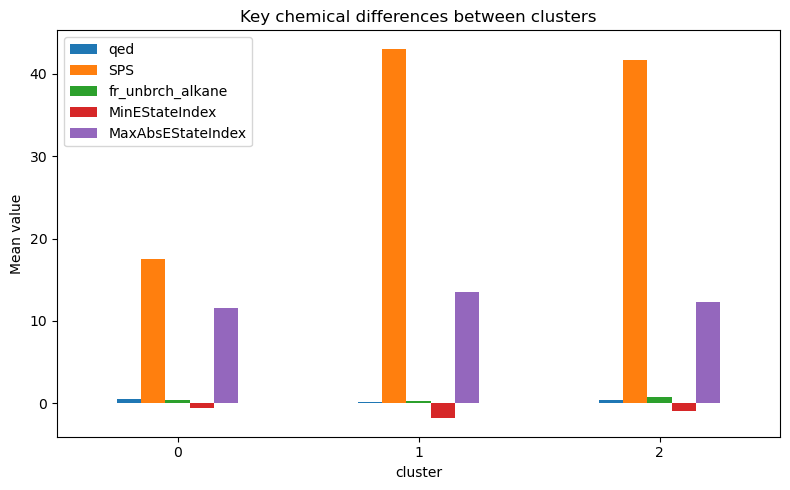

In [115]:
kmean_df.head(5)

cluster_means = (
    compOut_num
    .assign(cluster=kmean_df["cluster"].values)
    .groupby("cluster")
    .mean()
)

trans_cluster_mean = cluster_means.T

selected_features = [
    "qed",
    "SPS",
    "fr_unbrch_alkane",
    "MinEStateIndex",
    "MaxAbsEStateIndex"
]

cluster_means[selected_features].plot(kind="bar", figsize=(8,5))
plt.title("Key chemical differences between clusters")
plt.ylabel("Mean value")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Correlation Analysis
To explore relationships between chemical properties, a correlation matrix was calculated.
Hierarchical clustering was applied to reveal structure among the descriptors and identify redundant/highly correlated features, functional groups and possible trade-offs between chemical properties.


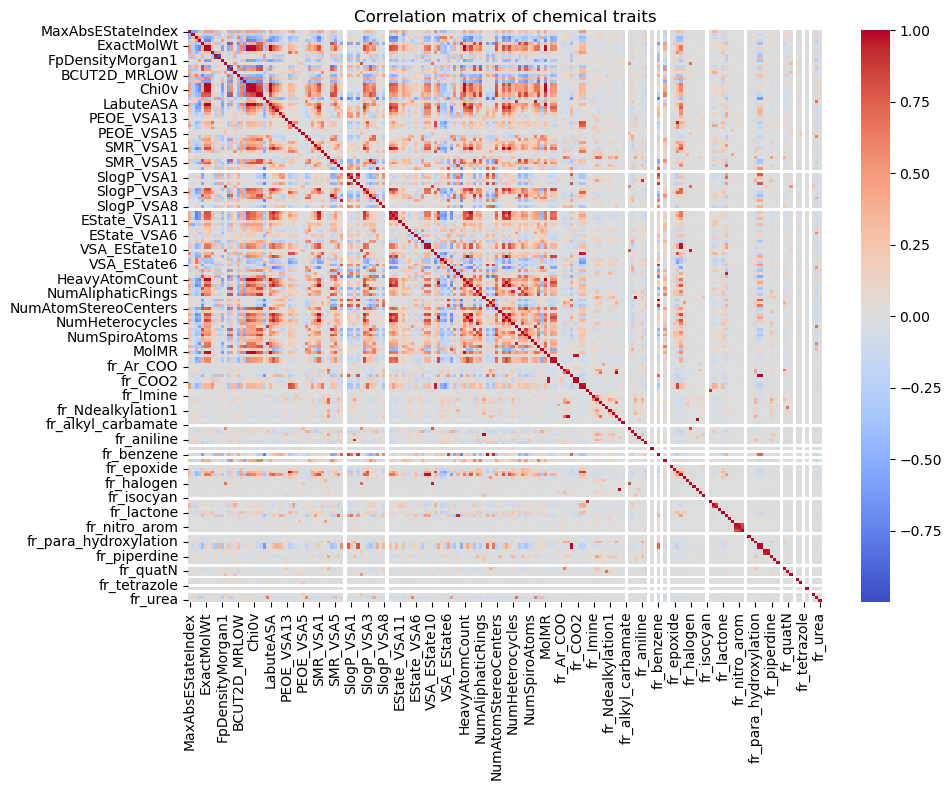

In [116]:
corr = compOut_num.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation matrix of chemical traits")
plt.tight_layout()
plt.show()

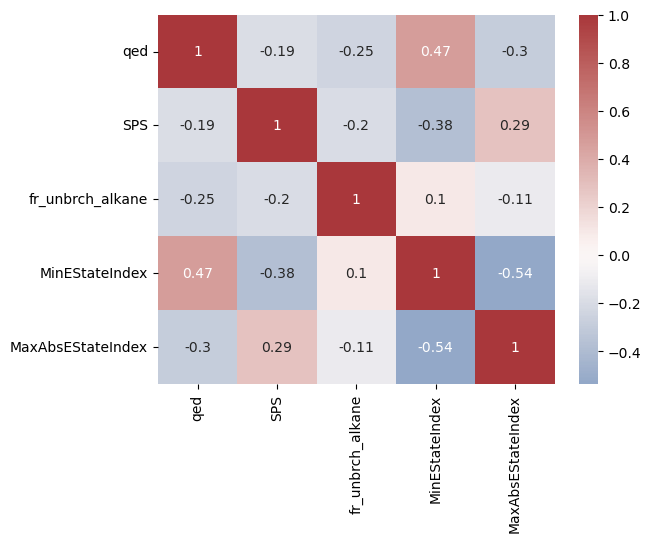

In [117]:
important = [
    "qed",
    "SPS",
    "MinEStateIndex",
    "MaxAbsEStateIndex",
    "fr_unbrch_alkane"
]

corr_small = compOut_num[selected_features].corr()

sns.heatmap(corr_small, annot=True, cmap="vlag", center=0)
plt.show()

### Summary
This analysis demonstrates that chemical descriptors alone reveal meaningful structure in the plant metabolome.


The combination of PCA, clustering as well as correlation analysis revealed:
- Continous molecular gradients and not clear categories
- Distinct clusters of metabolite chemotypes
- Structured relationships across molecular features

These findings support the interpretation that plant metabolism is organised in continous gradients rather than simple categories and shows a clear categories rather than random distributions.

In [118]:
import os

os.makedirs("modified_data",exist_ok=True)
desc_df.to_csv("modified_data/compound_descriptors.csv",index=False)
